In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [2]:
import galsim
from mdetsims import PowerSpectrumPSF

In [75]:
rng = np.random.RandomState(seed=24)

In [76]:
psf = PowerSpectrumPSF(rng=rng, im_width=225, scale=0.263, trunc=)

In [77]:
import tqdm

n = 20
fwhm = np.zeros((n, n))
g1 = np.zeros((n, n))
g2 = np.zeros((n, n))

for j, x in tqdm.tqdm(enumerate(np.linspace(0, 225, n))):
    for i, y in enumerate(np.linspace(0, 225, n)):
        pos = galsim.PositionD(x=x, y=y)
        _psf = psf.getPSF(pos)
        mom = galsim.hsm.FindAdaptiveMom(_psf.drawImage(scale=0.263, nx=33, ny=33))
        fwhm[i, j] = _psf.calculateFWHM()
        g1[i, j] = mom.observed_shape.g1
        g2[i, j] = mom.observed_shape.g2

20it [00:02,  9.21it/s]


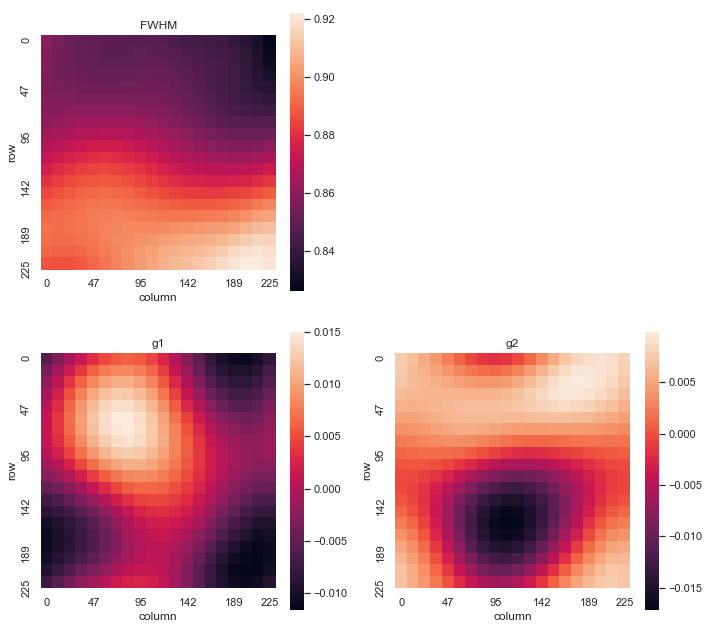

In [78]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 9))

xt = []
for i, _x in enumerate(np.linspace(0, 225, n)):
    if i % 4 == 0 or i == 0 or i == n - 1:
        xt.append("%0.0f" % _x)
    else:
        xt.append('')

ax = axs[0, 0]
sns.heatmap(
    fwhm, 
    ax=ax,
    square=True,
    xticklabels=xt,
    yticklabels=xt)
ax.set_xlabel('column')
ax.set_ylabel('row')
ax.set_title('FWHM')

ax = axs[0, 1]
ax.axis('off')

ax = axs[1, 0]
sns.heatmap(
    g1, 
    ax=ax, 
    square=True,
    xticklabels=xt,
    yticklabels=xt)
ax.set_xlabel('column')
ax.set_ylabel('row')
ax.set_title('g1')

ax = axs[1, 1]
sns.heatmap(
    g2, 
    ax=ax, 
    square=True,
    xticklabels=xt,
    yticklabels=xt)
ax.set_xlabel('column')
ax.set_ylabel('row')
ax.set_title('g2')

plt.tight_layout()